In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from video import *
import numpy as np
import ultralytics
import cv2 as cv
from utils import *
from tqdm import tqdm 
from ultralytics import RTDETR
from multiprocessing import Pool

In [3]:
fundamental_matrices = {
    "A" : {
        "B": np.load("fundamental_matrices/AB.npy"),
        "C": np.load("fundamental_matrices/AC.npy"),
    },
    "B": {
        "A": np.load("fundamental_matrices/BA.npy"),
        "C": np.load("fundamental_matrices/BC.npy"),
    },
    "C": {
        "B": np.load("fundamental_matrices/CB.npy"),
        "A": np.load("fundamental_matrices/CA.npy"),
    }
}

In [4]:
homography_matrices = {
    "A" : {
        "B": np.load("homography_matrices/AB.npy"),
        "C": np.load("homography_matrices/AC.npy"),
    },
    "B": {
        "A": np.load("homography_matrices/BA.npy"),
        "C": np.load("homography_matrices/BC.npy"),
    },
    "C": {
        "B": np.load("homography_matrices/CB.npy"),
        "A": np.load("homography_matrices/CA.npy"),
    }
}

In [5]:
video = "07"

In [6]:
if 'query' in globals():
    del query
if 'reference' in globals():
    del reference

a = load_video(f"train/task2/{video}_1.mp4")
b = load_video(f"train/task2/{video}_2.mp4")
print(a.num_frames())
print(b.num_frames())

375
228


In [7]:
camera_a = a.get_camera()
camera_b = b.get_camera()

print("A camera:", camera_a)
print("B camera:", camera_b)

A camera: A
B camera: C


In [8]:
F = fundamental_matrices[camera_a][camera_b] 
print(F)
F_inv = fundamental_matrices[camera_b][camera_a] 
print(F_inv)

[[-5.7527e-07  5.5402e-06  -0.0003995]
 [-9.7317e-06  7.1693e-06  -0.0036525]
 [   0.003172   0.0029729           1]]
[[-5.7527e-07 -9.7317e-06    0.003172]
 [ 5.5402e-06  7.1693e-06   0.0029729]
 [ -0.0003995  -0.0036525           1]]


In [9]:
H = homography_matrices[camera_a][camera_b]
print(H)
H_inv = homography_matrices[camera_b][camera_a]
print(H_inv)

[[     -4.734     -25.259       17296]
 [   -0.76251     -7.9624      3239.4]
 [ -0.0020016  -0.0028567           1]]
[[    0.82196     -1.7032      4155.6]
 [   -0.14479      2.8583     -238.45]
 [-0.00067971   0.0035915           1]]


In [10]:
def read_box(path):
    with open(path, "r") as f:
        lines = f.readlines()
    _, box = lines

    box = box.strip()
    _index, x1, y1, x2, y2 = list(map(int , box.split(" ")))
    return (x1, y1, x2, y2)

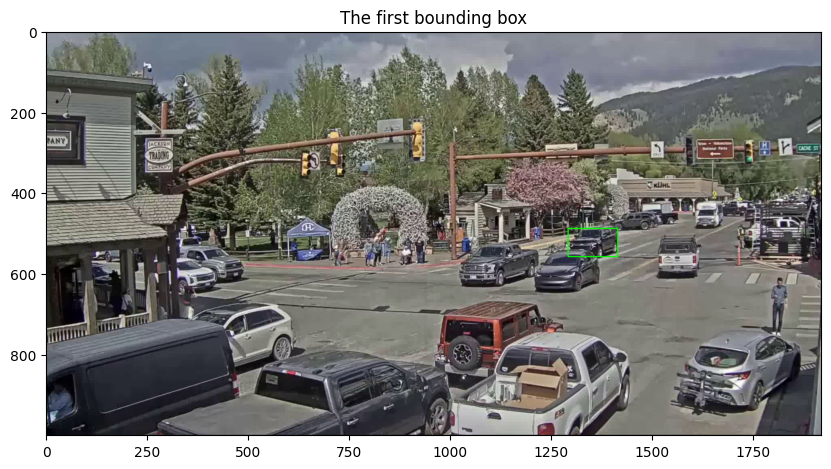

In [11]:
initial_bbox = read_box(f"train/task2/{video}_1.txt")
plot = a.get_frame(0).raw().copy()
cv.rectangle(plot, initial_bbox[:2], initial_bbox[2:], (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.title("The first bounding box")
plt.imshow(plot)

In [ ]:
a.do_tracking(visualize=True)
b.do_tracking(visualize=False)

In [13]:
def find_best_intersection(objects, bounding_box, threshold=0.5):
    max_iou = 0
    best = None

    for object in objects:
        bb = object["bbox"] 

        iou = bb_intersection_over_union(bb, bounding_box)
        if iou > threshold and iou > max_iou:
            best = object
            max_iou = iou

    return best 

In [14]:
def find_closest_object(objects, position, threshold=100):
    min_distance = np.inf
    best = None

    for object in objects:
        bb = object["bbox"]
        center= bounding_box_center(bb) 
        distance = np.linalg.norm(np.array(center) - np.array(position))

        if distance< threshold and distance < min_distance:
            best = object
            min_distance = distance
    return best

In [15]:
def compute_trajectory(video, initial_bbox, visualize=False):
    trajectory = []
    kalman = cv.KalmanFilter(8, 4)
    kalman.measurementMatrix = np.array(
                [[1, 0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0],
                ], np.float32)

    kalman.transitionMatrix = np.array(
                [[1, 0, 0, 0, 1, 0, 0, 0],
                [0, 1, 0, 0, 0, 1, 0, 0],
                [0, 0, 1, 0, 0, 0, 1, 0],
                [0, 0, 0, 1, 0, 0, 0, 1],
                [0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 0, 0, 1]
                ], np.float32)

    kalman.processNoiseCov = np.eye(8, dtype=np.float32) * 0.01

    kalman.measurementNoiseCov = np.array(
                [[200, 0, 0, 0],
                [0, 200, 0, 0],
                [0, 0, 1000, 0],
                [0, 0, 0, 1000]], np.float32)

    kalman.statePre = np.array([[initial_bbox[0]],
                                [initial_bbox[1]],
                                [initial_bbox[2] - initial_bbox[0]],
                                [initial_bbox[3] - initial_bbox[1]],
                                [0],
                                [0],
                                [0],
                                [0]], np.float32)

    kalman.statePost = np.array([[initial_bbox[0]],
                                [initial_bbox[1]],
                                [initial_bbox[2] - initial_bbox[0]],
                                [initial_bbox[3] - initial_bbox[1]],
                                [0],
                                [0],
                                [0],
                                [0]], np.float32)

    for frame_index in range(0, video.num_frames()):
        frame = video.get_frame(frame_index)
        objects = frame.objects()

        if visualize:
            plot = frame.raw().copy()
            for object in objects:
                cv.rectangle(plot, object["bbox"][:2], object["bbox"][2:], (0, 255, 0), 2)

        prediction = kalman.predict()[:4].flatten().astype(np.int32)
        prediction = (prediction[0], prediction[1], prediction[0] + prediction[2], prediction[1] + prediction[3])

        trajectory_point = (prediction[0] + prediction[2]) // 2, prediction[3] 
        trajectory.append(trajectory_point)

        # Proritize finding the best intersection with existing objects
        best_intersection = find_best_intersection(objects, prediction, threshold=0.2)

        found = None 
        if best_intersection is not None:
            found = best_intersection["bbox"]
        else:
            # If that fails, find the closest pbject.
            center = bounding_box_center(prediction)
            closest_object = find_closest_object(objects, center, threshold=50)
            if closest_object is not None:
                found = closest_object["bbox"]

        if found:
            kalman.correct(np.array([[found[0]], [found[1]], [found[2] - found[0]], [found[3] - found[1]]], np.float32))

        if visualize:
            cv.rectangle(plot, prediction[:2], prediction[2:], (255, 0, 0), 2)
            cv.imshow("tracking", plot)
            cv.waitKey(100)

    if visualize:
        cv.destroyAllWindows()
    
    return np.array(trajectory)

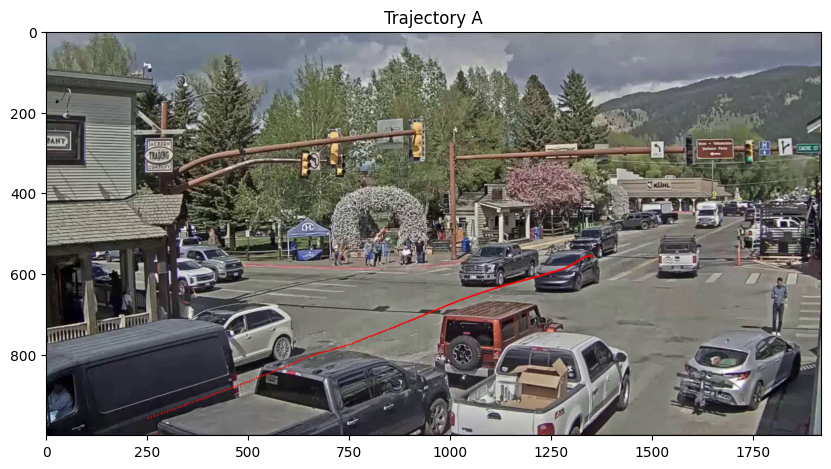

In [16]:
trajectory_a = compute_trajectory(a, initial_bbox, visualize=False)
plot = a.get_frame(0).raw().copy()
for point in trajectory_a:
    cv.circle(plot, point, 2, (255, 0, 0), -1)
plt.figure(figsize=(10, 10))
plt.title("Trajectory A")
plt.imshow(plot)

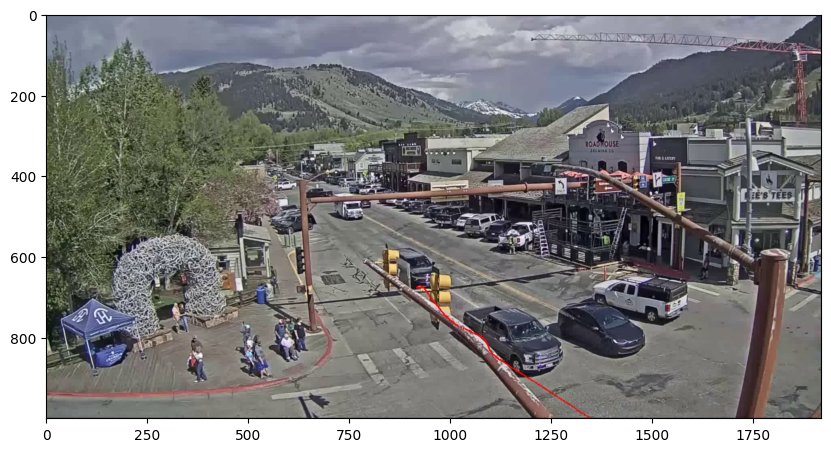

In [28]:
from time import time 

objects = b.get_frame(0).objects()

best_trajectory = None
min_cost = np.inf

for object in objects:
    trajectory_b = compute_trajectory(b, object["bbox"], visualize=False)

    cost = compare_trajectory(trajectory_a, trajectory_b, H, H_inv)
    if cost < min_cost:
        min_cost = cost
        best_trajectory = trajectory_b
    
plot = b.get_frame(0).raw().copy()
for point in best_trajectory:
    cv.circle(plot, point, 2, (255, 0, 0), -1)
plt.figure(figsize=(10, 10))
plt.imshow(plot)